In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Instead of doing an IC50 curve, where the dose-response is inhibition, I'd like to try a dose-response curve where the response is activation as a function of concentration.

In [2]:
x1 = np.vstack([np.linspace(-2, 2, 10)] * 5)
x2 = np.vstack([np.linspace(-2, 2, 10)] * 5)
x3 = np.vstack([np.linspace(-2, 2, 10)] * 5)

In [3]:
def dose_response(x, lower: float, upper: float, slope: float, c50: float):
    """
    :param x: Array of x-values.
    :param lower: Lower-plateau value
    :param upper: Upper-plateau value
    :param slope: Slope of dose response curve
    :param c50: The midpoint value of the curve.
    """

    return lower + (upper - lower) / (1 + np.exp(slope * (c50 - x)))


def noise(x, sd):
    return np.random.normal(0, scale=sd, size=x.shape)

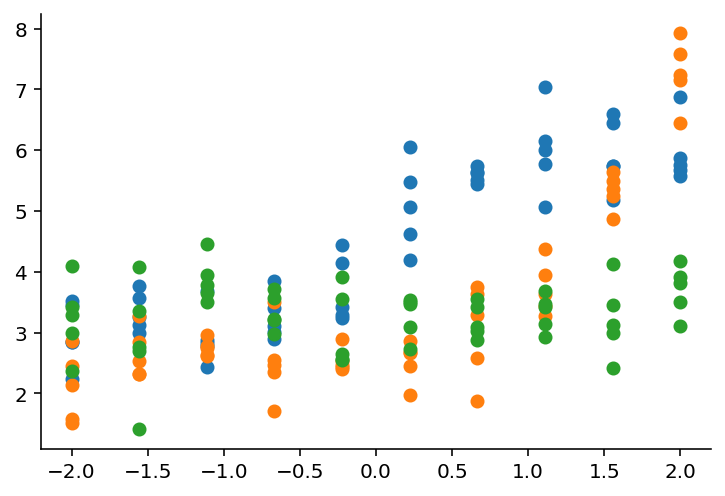

In [4]:
y1 = dose_response(x1, lower=3, upper=6, slope=4, c50=0) + noise(x1, 0.5)
y2 = dose_response(x2, lower=2.5, upper=8, slope=3, c50=1.5) + noise(x2, 0.5)
y3 = dose_response(x3, lower=3.2, upper=3.4, slope=1.5, c50=0.0) + noise(x3, 0.5)
plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.scatter(x3, y3)

Here, we have three separate curves.

- The blue one shows a nice and clean dose response relationship within the same bounds 
- The orange one shows an example where we do not hit 

In [5]:
df = pd.DataFrame(
    {
        "concentration": np.concatenate([x1.flatten(), x2.flatten(), x3.flatten()]),
        "response": np.concatenate([y1.flatten(), y2.flatten(), y3.flatten()]),
        "molecule": (
            [0] * len(x1.flatten()) + [1] * len(x2.flatten()) + [2] * len(x3.flatten())
        ),
    }
)

In [6]:
with pm.Model() as model:
    lower = pm.Normal("lower", mu=0, sd=10, shape=(3,))
    upper = pm.Normal("upper", mu=10, sd=10, shape=(3,))
    c50 = pm.Normal("c50", mu=0, sd=10, shape=(3,))
    slope = pm.HalfNormal("slope", sd=10, shape=(3,))

    mu = dose_response(
        df["concentration"],
        lower[df["molecule"].values],
        upper[df["molecule"].values],
        slope[df["molecule"].values],
        c50[df["molecule"].values],
    )

    sd = pm.HalfNormal("sd", sd=10, shape=(3,))
    y = pm.Normal("like", mu=mu, sd=sd[df["molecule"].values], observed=df["response"])

In [7]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, slope, c50, upper, lower]
Sampling 4 chains, 1,727 divergences: 100%|██████████| 10000/10000 [00:34<00:00, 286.33draws/s]
There were 479 divergences after tuning. Increase `target_accept` or reparameterize.
There were 493 divergences after tuning. Increase `target_accept` or reparameterize.
There were 413 divergences after tuning. Increase `target_accept` or reparameterize.
There were 342 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


/home/ericmjl/anaconda/envs/bayesian-analysis-recipes/lib/python3.8/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


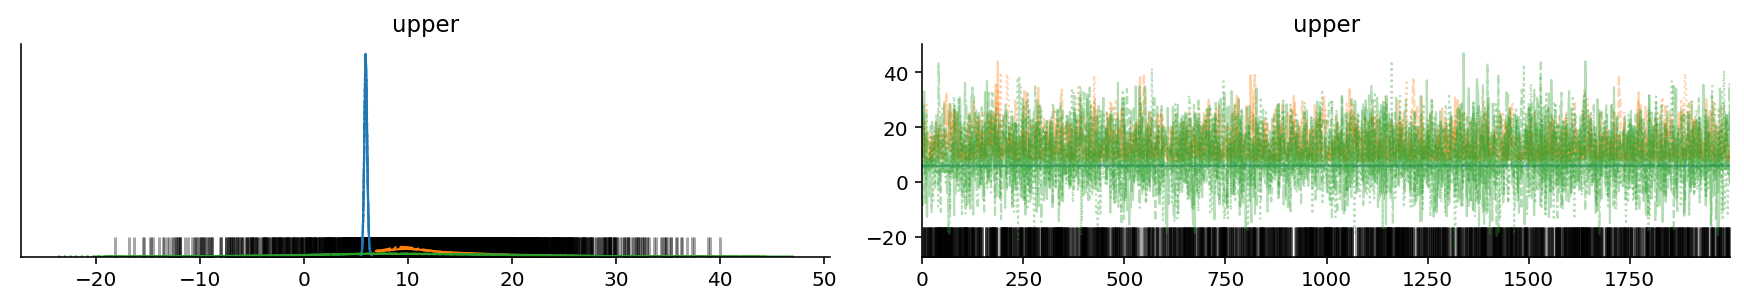

In [8]:
pm.traceplot(trace, varnames=["upper"])
plt.show()

It's clear that we have some unreasonable values, based on prior knowledge, which we did not encode in the model. 

Let's try a 2nd version of the model.

In [9]:
with pm.Model() as model_v2:
    # Group priors on lower
    lower_mu = pm.Normal("lower_mu", mu=0, sd=3)
    lower_sd = pm.Exponential("lower_sd", lam=5)
    # Prior on lower
    lower = pm.Normal("lower", mu=lower_mu, sd=lower_sd, shape=(3,))

    # Group prior on upper
    upper_mu = pm.Normal("upper_mu", mu=7, sd=3)
    upper_sd = pm.Exponential("upper_sd", lam=5)
    # Prior on upper
    upper = pm.Normal("upper", mu=upper_mu, sd=upper_sd, shape=(3,))

    # Group prior on c50
    c50_mu = pm.Normal("c50_mu", mu=0, sd=3)
    c50_sd = pm.Exponential("c50_sd", lam=5)
    # Prior on c50
    c50 = pm.Normal("c50", mu=c50_mu, sd=c50_sd, shape=(3,))

    # Group prior on slope
    slope_sd = pm.Exponential("slope_sd", lam=5)
    # Prior on slope
    slope = pm.HalfNormal("slope", sd=slope_sd, shape=(3,))

    # Transformation
    mu = dose_response(
        df["concentration"],
        lower[df["molecule"].values],
        upper[df["molecule"].values],
        slope[df["molecule"].values],
        c50[df["molecule"].values],
    )

    # Prior on SD
    sd = pm.HalfNormal("sd", sd=10, shape=(3,))

    # Likelihood
    y = pm.Normal("like", mu=mu, sd=sd[df["molecule"].values], observed=df["response"])

In [10]:
with model_v2:
    trace_v2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, slope, slope_sd, c50, c50_sd, c50_mu, upper, upper_sd, upper_mu, lower, lower_sd, lower_mu]
Sampling 4 chains, 34 divergences: 100%|██████████| 10000/10000 [00:27<00:00, 368.43draws/s]
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9113691245971718, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


/home/ericmjl/anaconda/envs/bayesian-analysis-recipes/lib/python3.8/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f036523c160>,
      dtype=object)

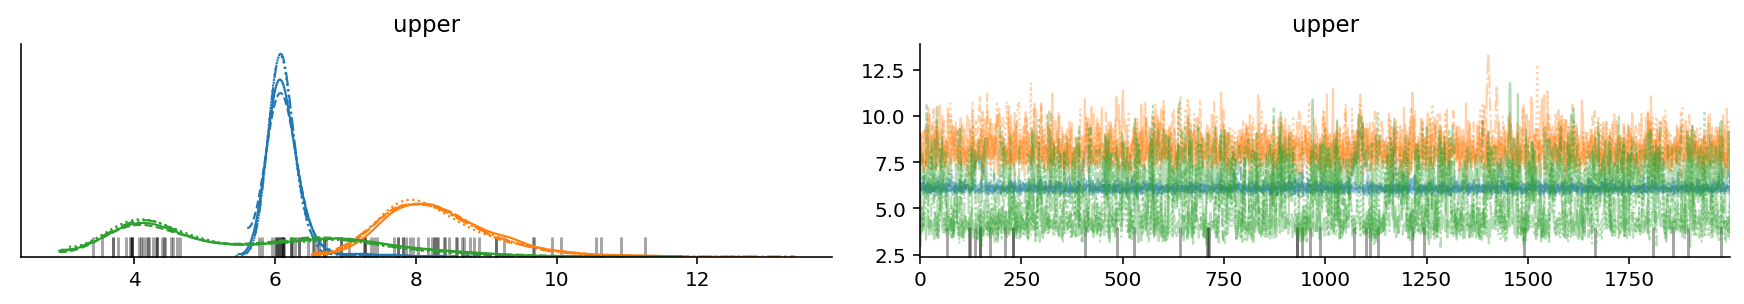

In [11]:
pm.traceplot(trace_v2, varnames=["upper"])

In [12]:
with pm.Model() as model_v3:
    # Main change here: switched lower and upper to gamma-distributed.

    # Group priors on lower
    lower_mu = pm.HalfNormal("lower_mu", sd=10)
    lower_sd = pm.Exponential("lower_sd", lam=5)
    # Prior on lower
    lower = pm.Gamma("lower", mu=lower_mu, sd=lower_sd, shape=(3,))

    # Group prior on upper
    upper_mu = pm.HalfNormal("upper_mu", sd=10)
    upper_sd = pm.Exponential("upper_sd", lam=5)
    # Prior on upper
    upper = pm.Gamma("upper", mu=upper_mu, sd=upper_sd, shape=(3,))

    # Group prior on c50
    c50_mu = pm.Normal("c50_mu", mu=0, sd=3)
    c50_sd = pm.Exponential("c50_sd", lam=5)
    # Prior on c50
    c50 = pm.Normal("c50", mu=c50_mu, sd=c50_sd, shape=(3,))

    # Group prior on slope
    slope_sd = pm.Exponential("slope_sd", lam=5)
    # Prior on slope
    slope = pm.HalfNormal("slope", sd=slope_sd, shape=(3,))

    # Transformation
    mu = dose_response(
        df["concentration"],
        lower[df["molecule"].values],
        upper[df["molecule"].values],
        slope[df["molecule"].values],
        c50[df["molecule"].values],
    )

    # Prior on SD
    sd = pm.HalfNormal("sd", sd=10, shape=(3,))

    # Likelihood
    y = pm.Normal("like", mu=mu, sd=sd[df["molecule"].values], observed=df["response"])

In [13]:
with model_v3:
    trace_v3 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, slope, slope_sd, c50, c50_sd, c50_mu, upper, upper_sd, upper_mu, lower, lower_sd, lower_mu]
Sampling 4 chains, 75 divergences: 100%|██████████| 10000/10000 [00:34<00:00, 293.93draws/s]
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7161589402283773, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


/home/ericmjl/anaconda/envs/bayesian-analysis-recipes/lib/python3.8/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f035f42b100>,
      dtype=object)

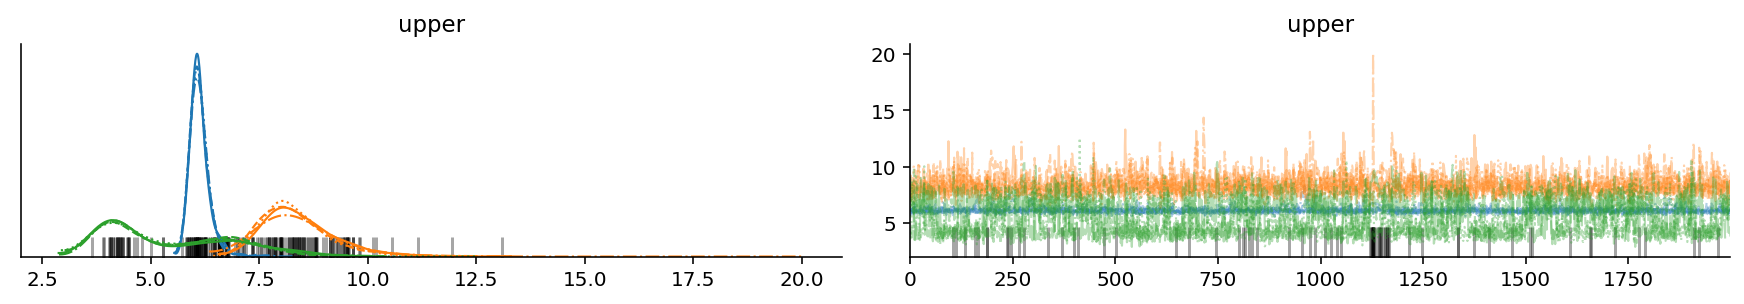

In [14]:
pm.traceplot(trace_v3, varnames=["upper"])

In [15]:
upper = trace_v3["upper"].mean(axis=0)

In [16]:
upper

array([6.115337 , 8.349469 , 5.3776417], dtype=float32)